### **1. Importing necessary libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import keras
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from utils.utils import split_data

2024-03-20 21:41:27.829020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-20 21:41:28.492671: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### **2. CNN Model**

In [3]:
# loading model
model = keras.models.load_model('./models/trained/cnn_model.h5')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 225, 225, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 110, 110, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 55, 55, 32)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 96800)             0         
                                                                 
 dense (Dense)               (None, 1)                 9

2024-03-20 21:41:29.397416: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-20 21:41:29.426271: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# loading model's history
with open('./models/historys/cnn_model_history', 'rb') as f:
    history = pickle.load(f)

#### 2.1 Curves

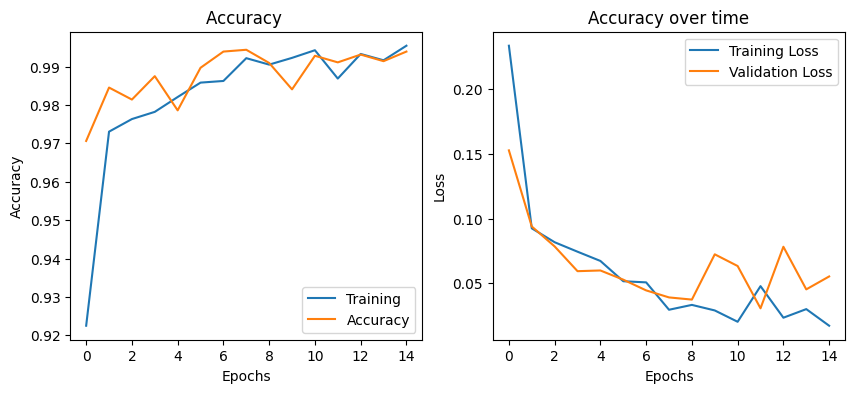

In [5]:
plt.figure(figsize = (10, 4))

plt.subplot(1, 2, 1)
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title("Accuracy ")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Training", "Accuracy"])

plt.subplot(1, 2, 2)
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Accuracy over time")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training Loss", "Validation Loss"])

plt.show()

#### 2.2 Loading datas

In [4]:
#load dataset
dataset = pd.read_csv('../dataset/dataset_final.csv')

# refactor values in filepath column added ../ to the path
dataset['Filepath'] = dataset['Filepath'].apply(lambda x: '../' + x)

dataset.head()

,Filepath,Label
0,../dataset/Positive/07045.jpg,POSITIVE
1,../dataset/Positive/09452.jpg,POSITIVE
2,../dataset/Positive/19030_1.jpg,POSITIVE
3,../dataset/Negative/06463.jpg,NEGATIVE
4,../dataset/Positive/12625_1.jpg,POSITIVE


In [5]:
#split dataset
train_df, test_df = train_test_split(
    dataset.sample(frac=1.0, random_state=42), train_size=0.80, random_state=42)

# train, validation and test datas
train_data, validation_data, test_data = split_data(train_df, test_df)
print(f"Total de imagens de treino: {train_data.samples}, Total de imagens de validação: {validation_data.samples}, Total de imagens de teste: {test_data.samples}")


Found 25600 validated image filenames belonging to 2 classes.
Found 6400 validated image filenames belonging to 2 classes.
Found 8000 validated image filenames belonging to 2 classes.
Total de imagens de treino: 25600, Total de imagens de validação: 6400, Total de imagens de teste: 8000


#### 2.3 Testing the model

In [6]:
y_pred = np.squeeze(model.predict(test_data) >= 0.5).astype(np.int32)

250/250 [==============================] - 11s 44ms/step


In [6]:
from sklearn.metrics import f1_score, precision_score, recall_score

x = f1_score(test_data.labels, y_pred, average= 'weighted')
y = precision_score(test_data.labels, y_pred, average= 'weighted')
z = recall_score(test_data.labels, y_pred, average= 'weighted')

print(f"F1 Score: {x}")
print(f"Precision Score: {y}")
print(f"Recall Score: {z}")

F1 Score: 0.9863744092158784
Precision Score: 0.9865472384462355
Recall Score: 0.986375


In [8]:
results = model.evaluate(test_data)

# assigning the results into loss and accuracy
loss = results[0]
accuracy = results[1]

# showing up the results
print(f"Model's accuracy: {(accuracy*100):0.2f}%")
print(f"Model's loss: {(loss):0.2f}")

250/250 [==============================] - 37s 149ms/step - loss: 0.0426 - accuracy: 0.9864
Model's accuracy: 98.64%
Model's loss: 0.04


               precision    recall  f1-score   support

Without crack       0.98      1.00      0.99      3981
   With crack       1.00      0.98      0.99      4019

     accuracy                           0.99      8000
    macro avg       0.99      0.99      0.99      8000
 weighted avg       0.99      0.99      0.99      8000



Text(0, 0.5, 'Real')

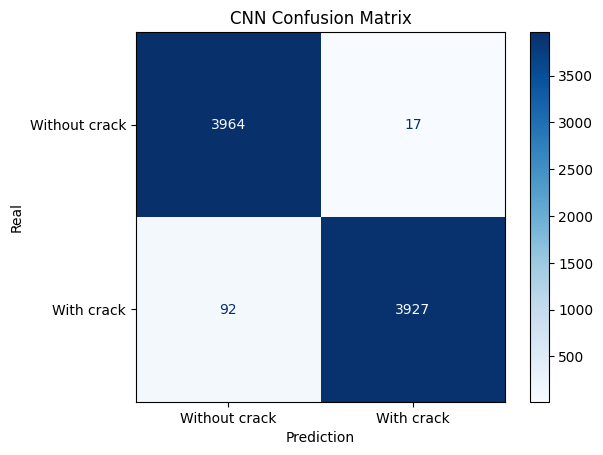

In [7]:
# creating the confusion matrix
matrix = confusion_matrix(test_data.labels, y_pred)
classifications = classification_report(test_data.labels, y_pred, target_names = ["Without crack", "With crack"])
display = ConfusionMatrixDisplay(matrix, display_labels = ["Without crack", "With crack"])

print(classifications)

# ploting the Matrix
display.plot(cmap=plt.cm.Blues)
display.ax_.set_title('CNN Confusion Matrix')
display.ax_.set_xlabel('Prediction')
display.ax_.set_ylabel('Real')

In [8]:
display.figure_.savefig('./models/figures/CNN-confusion-matrix.png')
display.figure_.savefig('./models/figures/CNN-confusion-matrix.eps')